# Banka Müşteri Davranışı Analizi ve Tahmin Projesi

## Proje Amacı


#### Bu makine öğrenmesi projesinin temel amacı, bir bankanın telefonla yaptığı pazarlama kampanyalarına müşterilerin vereceği yanıtı (vadeli mevduat hesabı açıp açmayacaklarını) tahmin etmektir. Bu tahmin sayesinde bankanın:
#### *  Pazarlama kaynaklarını daha verimli kullanması,
#### *  Doğru müşteri segmentlerine odaklanması,
#### * Müşteri deneyimini iyileştirmesi,
#### * Kampanya maliyetlerini düşürmesi hedeflenmektedir.


## Veri Seti Hakkında

### Kullandığımız veri seti, Portekiz'deki bir bankanın telefonla pazarlama kampanyalarına ait verileri içermektedir.

#### *  21 özellik (demografik, finansal ve kampanyaya özel),
#### *  20.000 gözlem (orijinal veriden örneklenmiş),
#### *  Tarih aralığı: Mayıs 2008 - Kasım 2010

# Kütüphanelerin Yüklenmesi
> ### *Makine öğrenmesi projemizde verileri analiz etmek, görselleştirmek ve modelleme işlemlerini gerçekleştirmek için çeşitli Python kütüphanelerini kullandık. Bu kütüphaneler aşağıda listelenmiştir:*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Verinin Yüklenmesi ve Örneklenmesi
#### *Projeye ilk adım olarak, bankanın pazarlama kampanyalarına ait verileri içeren CSV formatındaki dosyayı pandas kütüphanesi yardımıyla yüklüyoruz. Daha sonra, veri seti oldukça büyük olduğu için (yaklaşık 41.000 gözlem içeriyor), analiz sürecini hızlandırmak ve daha yönetilebilir hale getirmek amacıyla bu veriden rastgele 20.000 satırlık bir örneklem alıyoruz.*

In [2]:
# Veriyi okuma
data = pd.read_csv('/kaggle/input/bank-churn/bank-additional-full.csv')
# Çalışmaları daha hızlı ve verimli yapabilmek için veri setinden 20.000 örnek seçtim
data = data.sample(n=20000, random_state=42)

# Veriye İlk Bakış: Boyut, İçerik ve Türler
> ### *Modelleme aşamasına geçmeden önce veri setini genel hatlarıyla tanımak önemli. Bu adımda, verinin ilk birkaç satırını inceleyerek sütun yapısını gözlemliyor, toplam kaç satır ve sütun içerdiğini öğreniyor ve her bir değişkenin veri tipini kontrol ediyoruz.*

In [3]:
# Veri setinin ilk 5 satırını görüntüledim
print("Veri setinin ilk 5 satırı:")
display(data.head())

# Kaç satır ve sütundan oluştuğuna baktım
print("\nVeri seti boyutu:", data.shape)

# Hangi sütunun hangi veri türünde olduğunu inceledim
print("\nDeğişken tipleri:")
print(data.dtypes)

Veri setinin ilk 5 satırı:


,"age;""job"";""marital"";""education"";""default"";""housing"";""loan"";""contact"";""month"";""day_of_week"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""emp.var.rate"";""cons.price.idx"";""cons.conf.idx"";""euribor3m"";""nr.employed"";""y"""
32884,"57;""technician"";""married"";""high.school"";""no"";""..."
3169,"55;""unknown"";""married"";""unknown"";""unknown"";""ye..."
32206,"33;""blue-collar"";""married"";""basic.9y"";""no"";""no..."
9403,"36;""admin."";""married"";""high.school"";""no"";""no"";..."
14020,"27;""housemaid"";""married"";""high.school"";""no"";""y..."



Veri seti boyutu: (20000, 1)

Değişken tipleri:
age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"    object
dtype: object


## Bu adımlarla:
##### Veride neler olduğunu genel olarak görmüş oluyoruz.

##### Hangi sütunların sayısal, hangilerinin kategorik olduğunu anlayarak sonraki ön işleme adımlarına zemin hazırlıyoruz.

##### Eksik ya da beklenmedik veri türleri varsa erkenden fark etme şansımız oluyor.

# Verinin Daha Doğru Okunması ve Sütun Adlarının Türkçeleştirilmesi

> ### *Veri seti varsayılan olarak ; ile ayrılmış ve bazı sütunlarda tırnak işaretleri veya binlik ayraçlar içerebilir. Bu nedenle, veriyi daha doğru ve hatasız şekilde yüklemek için read_csv() fonksiyonunda bazı özel parametreler kullandım.* *Ayrıca analiz sürecinde daha rahat çalışmak adına sütun isimlerini Türkçeye çevirdim. Bu sayede sütunlar daha anlaşılır hale geldi.*


In [4]:
# CSV dosyasını doğru biçimde okuyorum
data = pd.read_csv('/kaggle/input/bank-churn/bank-additional-full.csv', 
                 sep=';', 
                 quotechar='"',
                 thousands=',',  # Sayısal değerlerde binlik ayracı varsa
                 encoding='utf-8')

# Sütun adlarını Türkçeleştirdim
column_translation = {
    'age': 'Yaş',
    'job': 'Meslek',
    'marital': 'Medeni Durum',
    'education': 'Eğitim Seviyesi',
    'default': 'Kredi Geçmişi',
    'housing': 'Konut Kredisi',
    'loan': 'Bireysel Kredi',
    'contact': 'İletişim Türü',
    'month': 'Ay',
    'day_of_week': 'Haftanın Günü',
    'duration': 'Görüşme Süresi (sn)',
    'campaign': 'Kampanya Temas Sayısı',
    'pdays': 'Önceki Temastan Sonra Geçen Gün',
    'previous': 'Önceki Kampanya Temas Sayısı',
    'poutcome': 'Önceki Kampanya Sonucu',
    'emp.var.rate': 'İstihdam Değişim Oranı',
    'cons.price.idx': 'Tüketici Fiyat Endeksi',
    'cons.conf.idx': 'Tüketici Güven Endeksi',
    'euribor3m': '3 Aylık EURIBOR Oranı',
    'nr.employed': 'Çalışan Sayısı',
    'y': 'Mevduat Aboneliği'
}

# Yeni sütun isimlerini uyguluyorum
data = data.rename(columns=column_translation)

## Bu adımla:
##### *CSV dosyasındaki olası biçimlendirme sorunlarını engelledim.*

##### *Daha okunabilir ve anlaşılır sütun adları sayesinde analiz sürecini kolaylaştırdım.*

# Kategorik Değişkenlerin Türkçeleştirilmesi
### > Veri setinde bazı sütunlar İngilizce kategorik etiketler içeriyor. Bu etiketleri Türkçeye çevirerek veriyi daha okunabilir ve anlaşılır hale getirdim. Bu sayede grafik ve raporlarda doğrudan Türkçe ifadeler kullanılabilir hale geldi.

In [5]:
# Meslek bilgilerini Türkçeye çevirdim
meslek_ceviri = {
    'admin.': 'Yönetici',
    'blue-collar': 'Mavi Yakalı',
    'technician': 'Teknisyen',
    'services': 'Hizmet',
    'management': 'Üst Düzey Yönetici',
    'retired': 'Emekli',
    'entrepreneur': 'Girişimci',
    'self-employed': 'Serbest Meslek',
    'housemaid': 'Ev Hizmetleri',
    'unemployed': 'İşsiz',
    'student': 'Öğrenci',
    'unknown': 'Bilinmiyor'
}

data['Meslek'] = data['Meslek'].map(meslek_ceviri)

# Medeni durum bilgilerini çevirdim
data['Medeni Durum'] = data['Medeni Durum'].map({
    'married': 'Evli',
    'single': 'Bekar',
    'divorced': 'Boşanmış',
    'unknown': 'Bilinmiyor'
})

# Eğitim seviyelerini daha açıklayıcı hale getirdim
data['Eğitim Seviyesi'] = data['Eğitim Seviyesi'].str.replace('basic.', 'Temel Eğitim ')
data['Eğitim Seviyesi'] = data['Eğitim Seviyesi'].replace({
    'high.school': 'Lise',
    'university.degree': 'Üniversite',
    'professional.course': 'Mesleki Kurs',
    'unknown': 'Bilinmiyor'
})

# Hedef değişken olan 'Mevduat Aboneliği' değerlerini çevirdim
data['Mevduat Aboneliği'] = data['Mevduat Aboneliği'].map({
    'yes': 'Evet',
    'no': 'Hayır'
})

## Bu adımlarla:
##### Görselleştirmelerde ve sonuç raporlarında daha anlaşılır etiketler elde ettim.

##### Özellikle hedef değişkenin (“Mevduat Aboneliği”) Türkçeleştirilmesi, model yorumlamasını kolaylaştırdı.

# Daha Okunaklı Önizleme Fonksiyonu
#### > Verinin ilk birkaç satırına tekrar göz atmak istedim ama bu kez daha okunabilir ve sade bir görünümle. Bu amaçla, kendi küçük fonksiyonumu yazdım. Bu fonksiyon sayesinde sütun başlıkları ve hücreler sola yaslı bir şekilde gösteriliyor, bu da tabloyu daha profesyonel ve rahat okunur hale getiriyor.

In [6]:
# Daha sade ve okunabilir tablo görünümü için bir fonksiyon
def show_data(data, rows=5):
    display(data.head(rows).style
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))

# Fonksiyonu çağırarak verinin ilk 5 satırı
show_data(data)

,Yaş,Meslek,Medeni Durum,Eğitim Seviyesi,Kredi Geçmişi,Konut Kredisi,Bireysel Kredi,İletişim Türü,Ay,Haftanın Günü,Görüşme Süresi (sn),Kampanya Temas Sayısı,Önceki Temastan Sonra Geçen Gün,Önceki Kampanya Temas Sayısı,Önceki Kampanya Sonucu,İstihdam Değişim Oranı,Tüketici Fiyat Endeksi,Tüketici Güven Endeksi,3 Aylık EURIBOR Oranı,Çalışan Sayısı,Mevduat Aboneliği
0,56,Ev Hizmetleri,Evli,Temel Eğitim 4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,Hayır
1,57,Hizmet,Evli,Lise,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,Hayır
2,37,Hizmet,Evli,Lise,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,Hayır
3,40,Yönetici,Evli,Temel Eğitim 6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,Hayır
4,56,Hizmet,Evli,Lise,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,Hayır


# Güncellenmiş Veriden Yeni Örneklem Alma
> #### Veri seti üzerinde bazı çeviri ve temizlik işlemlerini yaptıktan sonra, bu güncel halinden tekrar 20.000 satırlık bir örnekleme alıyorum. Böylece analiz ve modelleme işlemlerinde hem Türkçeleştirilmiş hem de daha az satırlı, işlenmiş bir veri setiyle çalışmış oluyorum.

In [7]:
# Veri setini 20.000 satıra düşürme
data = data.sample(n=20000, random_state=42)

# Veri Setinin Güncel Boyutunu Kontrol Etme
> #### Tüm ön işlemler ve örnekleme tamamlandıktan sonra, elimde kalan verinin kaç satır ve kaç sütundan oluştuğunu hızlıca kontrol ettim.

In [8]:
data.shape

(20000, 21)

# 📊 Veri Setine Genel Bakış ve Hedef Değişken Dağılımı
> #### Modeli kurmadan önce verinin genel yapısını daha iyi anlamak için bazı temel istatistiklere baktım. Bu adımda hem veri setinin boyutunu hem de "Mevduat Aboneliği" hedef değişkeninin dağılımını inceledim.

In [9]:
# Veri setinin temel istatistikleri
print(f"Toplam gözlem sayısı: {data.shape[0]}")
print(f"Özellik sayısı: {data.shape[1]}")
print("\nHedef değişken dağılımı:")
print(data['Mevduat Aboneliği'].value_counts(normalize=True))

Toplam gözlem sayısı: 20000
Özellik sayısı: 21

Hedef değişken dağılımı:
Mevduat Aboneliği
Hayır    0.8886
Evet     0.1114
Name: proportion, dtype: float64


## Bu adımla:
##### Modelin dengesiz sınıflarla karşılaşıp karşılaşmayacağını önceden görebildim.

##### Hedef değişkenin çoğunlukla hangi sınıfa ait olduğunu anlayarak modelin tahmin başarısını daha bilinçli yorumlayabileceğim.

# Eksik Veri ve Kategorik Değişkenlerin İncelenmesi
> #### Veri kalitesi ve modelleme sürecinin sağlıklı ilerleyebilmesi için öncelikle eksik veri kontrolü yaptım. Ayrıca kategorik değişkenlerde kaç farklı benzersiz değer olduğunu kontrol ederek, veri çeşitliliği hakkında bilgi edindim.

In [10]:
# Eksik veri kontrolü
print("\nEksik veri analizi:")
print(data.isnull().sum())

# Kategorik değişken analizi
print("\nKategorik değişkenlerin benzersiz değerleri:")
for col in data.select_dtypes(include=['object']).columns:
    print(f"{col}: {data[col].nunique()} unique value")


Eksik veri analizi:
Yaş                                0
Meslek                             0
Medeni Durum                       0
Eğitim Seviyesi                    0
Kredi Geçmişi                      0
Konut Kredisi                      0
Bireysel Kredi                     0
İletişim Türü                      0
Ay                                 0
Haftanın Günü                      0
Görüşme Süresi (sn)                0
Kampanya Temas Sayısı              0
Önceki Temastan Sonra Geçen Gün    0
Önceki Kampanya Temas Sayısı       0
Önceki Kampanya Sonucu             0
İstihdam Değişim Oranı             0
Tüketici Fiyat Endeksi             0
Tüketici Güven Endeksi             0
3 Aylık EURIBOR Oranı              0
Çalışan Sayısı                     0
Mevduat Aboneliği                  0
dtype: int64

Kategorik değişkenlerin benzersiz değerleri:
Meslek: 12 unique value
Medeni Durum: 4 unique value
Eğitim Seviyesi: 8 unique value
Kredi Geçmişi: 3 unique value
Konut Kredisi: 3 unique valu

## Bu adımla:
##### Veride eksik değer olup olmadığını netleştirdim, böylece gerekli önlemleri planlayabilirim.

##### Kategorik sütunların çeşitliliğini öğrenerek, ön işleme ve kodlama yöntemlerini belirlemek için önemli ipuçları aldım.

# Hedef Değişkenin Kodlanması ve Kategorik Verilerin One-Hot Encoding ile Sayısallaştırılması

> #### Makine öğrenmesi modelleri sayısal verilerle çalıştığı için hedef değişkenimizi ve kategorik değişkenlerimizi uygun şekilde kodladım. Öncelikle, hedef değişken olan “Mevduat Aboneliği”ni LabelEncoder ile 0 ve 1 değerlerine çevirdim. Ardından, kategorik değişkenlerde çoklu kategorilerin etkili bir şekilde modele dahil edilmesi için One-Hot Encoding uyguladım. Böylece her kategori için ayrı bir sütun oluşturuldu. drop_first=True parametresiyle gereksiz çoklu kolonlardan kaçınıp modelde multikolineariteyi azalttım.


In [11]:
# Hedef değişkeni kodla
le = LabelEncoder()
data['Mevduat Aboneliği'] = le.fit_transform(data['Mevduat Aboneliği'])

# Kategorik değişkenleri seç
categorical_columns = ['Meslek', 'Medeni Durum', 'Eğitim Seviyesi', 'Kredi Geçmişi', 
                      'Konut Kredisi', 'Bireysel Kredi', 'İletişim Türü', 'Ay', 
                      'Haftanın Günü', 'Önceki Kampanya Sonucu']

# One-Hot Encoding uygula
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Kodlanmış veri setini kontrol et
data_encoded.head()

,Yaş,Görüşme Süresi (sn),Kampanya Temas Sayısı,Önceki Temastan Sonra Geçen Gün,Önceki Kampanya Temas Sayısı,İstihdam Değişim Oranı,Tüketici Fiyat Endeksi,Tüketici Güven Endeksi,3 Aylık EURIBOR Oranı,Çalışan Sayısı,...,Ay_may,Ay_nov,Ay_oct,Ay_sep,Haftanın Günü_mon,Haftanın Günü_thu,Haftanın Günü_tue,Haftanın Günü_wed,Önceki Kampanya Sonucu_nonexistent,Önceki Kampanya Sonucu_success
32884,57,371,1,999,1,-1.8,92.893,-46.2,1.299,5099.1,...,True,False,False,False,True,False,False,False,False,False
3169,55,285,2,999,0,1.1,93.994,-36.4,4.860,5191.0,...,True,False,False,False,False,True,False,False,True,False
32206,33,52,1,999,1,-1.8,92.893,-46.2,1.313,5099.1,...,True,False,False,False,False,False,False,False,False,False
9403,36,355,4,999,0,1.4,94.465,-41.8,4.967,5228.1,...,False,False,False,False,False,False,False,False,True,False
14020,27,189,2,999,0,1.4,93.918,-42.7,4.963,5228.1,...,False,False,False,False,False,False,False,False,True,False


## Bu adımla:
##### Hedef değişken model için uygun hale getirildi.

##### Kategorik veriler sayısal sütunlara dönüştürülerek modelin tüm bilgiyi kullanması sağlandı.

# Sayısal Değişkenlerin Standartlaştırılması (Ölçeklendirme)

> #### Modelin daha sağlıklı ve hızlı öğrenmesi için sayısal değişkenleri aynı ölçeğe getirdim. Çünkü farklı ölçeklerdeki veriler modelin performansını olumsuz etkileyebilir.Öncelikle, sayısal sütunları seçtim.Ardından, StandardScaler ile bu sayısal verileri ortalaması 0, standart sapması 1 olacak şekilde standartlaştırdım.Bu işlem, özellikle mesafe tabanlı algoritmalar ve ağaç tabanlı modellerde dengeli sonuçlar alınmasına yardımcı olur.


In [12]:
# Sayısal değişkenleri seç
numerical_columns = ['Yaş', 'Görüşme Süresi (sn)', 'Kampanya Temas Sayısı', 
                    'Önceki Temastan Sonra Geçen Gün', 'Önceki Kampanya Temas Sayısı', 
                    'İstihdam Değişim Oranı', 'Tüketici Fiyat Endeksi', 
                    'Tüketici Güven Endeksi', '3 Aylık EURIBOR Oranı', 'Çalışan Sayısı']

# Ölçeklendirme
scaler = StandardScaler()
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

# Ölçeklenmiş veri setini kontrol et
data_encoded.head()

,Yaş,Görüşme Süresi (sn),Kampanya Temas Sayısı,Önceki Temastan Sonra Geçen Gün,Önceki Kampanya Temas Sayısı,İstihdam Değişim Oranı,Tüketici Fiyat Endeksi,Tüketici Güven Endeksi,3 Aylık EURIBOR Oranı,Çalışan Sayısı,...,Ay_may,Ay_nov,Ay_oct,Ay_sep,Haftanın Günü_mon,Haftanın Günü_thu,Haftanın Günü_tue,Haftanın Günü_wed,Önceki Kampanya Sonucu_nonexistent,Önceki Kampanya Sonucu_success
32884,1.626817,0.442113,-0.561156,0.199019,1.650361,-1.196329,-1.177626,-1.236624,-1.340504,-0.946867,...,True,False,False,False,True,False,False,False,False,False
3169,1.434541,0.107803,-0.199552,0.199019,-0.351654,0.650895,0.725289,0.891953,0.715450,0.332751,...,True,False,False,False,False,True,False,False,True,False
32206,-0.680493,-0.797942,-0.561156,0.199019,1.650361,-1.196329,-1.177626,-1.236624,-1.332421,-0.946867,...,True,False,False,False,False,False,False,False,False,False
9403,-0.392079,0.379916,0.523658,0.199019,-0.351654,0.841987,1.539342,-0.280936,0.777227,0.849333,...,False,False,False,False,False,False,False,False,True,False
14020,-1.257320,-0.265379,-0.199552,0.199019,-0.351654,0.841987,0.593934,-0.476418,0.774918,0.849333,...,False,False,False,False,False,False,False,False,True,False


## Bu adımla:
##### Sayısal değişkenler aynı ölçek aralığına çekildi.

##### Modelin farklı değişkenlere eşit ağırlık vermesi sağlandı.

# Veri Setini Eğitim ve Test Olarak Bölme

> #### Modeli eğitirken, veriyi ikiye ayırmak gerekiyor: biri modeli öğrenmesi için eğitim, diğeri ise performansını sınamak için test verisi.Bağımsız değişkenleri (özellikler) ve hedef değişkeni ayırdım.Veri setini %80 eğitim, %20 test olarak böldüm.stratify=y parametresi ile hedef değişkenin dağılımının eğitim ve test setinde aynı oranda kalmasını sağladım.random_state=42 ile her çalıştırmada aynı bölünmenin yapılması garanti edildi.


In [13]:
X = data_encoded.drop('Mevduat Aboneliği', axis=1)
y = data_encoded['Mevduat Aboneliği']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

 # Random Forest Modeli Eğitimi ve Performans Değerlendirmesi

> #### Veri hazırlandıktan sonra, güçlü ve popüler sınıflandırma algoritmalarından biri olan Random Forest modelini kullandım.Modeli, eğitim verisi üzerinde fit metodu ile eğittim.Test verisi üzerinde tahminler yaparak performansını ölçtüm.class_weight='balanced' parametresi ile dengesiz sınıflar için ağırlıklandırma yaptım, böylece model azınlık sınıfı daha iyi öğrenebilsin.Sonuçları classification_report ile detaylı olarak değerlendirdim.Ayrıca, tahminlerin doğruluğunu görsel olarak anlamak için karışıklık (confusion) matrisini çizdim.


Random Forest Performansı:
              precision    recall  f1-score   support

           0       0.63      0.42      0.50       446
           1       0.93      0.97      0.95      3554

    accuracy                           0.91      4000
   macro avg       0.78      0.69      0.73      4000
weighted avg       0.90      0.91      0.90      4000



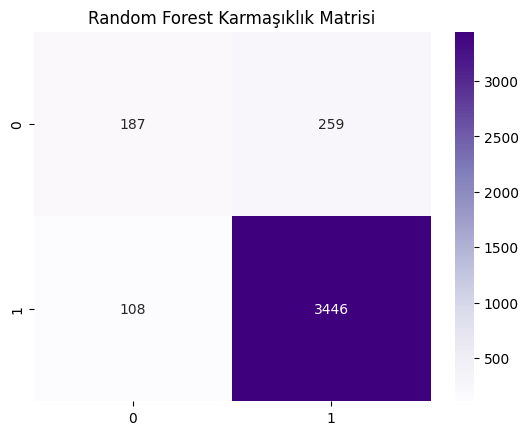

In [14]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performansı:")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Purples')
plt.title('Random Forest Karmaşıklık Matrisi')
plt.show()

## Bu adımla:
##### Modelin doğruluk, hassasiyet, geri çağırma ve F1 skorlarını detaylıca inceledim.

##### Hangi sınıflarda modelin iyi veya kötü performans gösterdiğini karışıklık matrisi ile görsel olarak değerlendirdim.

# XGBoost Modeli Eğitimi ve Performans Analizi

> #### Modelleme sürecine güçlü bir diğer algoritma olan XGBoost’u dahil ettim. XGBoost, yüksek performanslı ve hızlı çalışan bir gradyan artırma (gradient boosting) algoritmasıdır.Veri dengesizliğini dikkate almak için scale_pos_weight parametresini pozitif ve negatif sınıfların oranına göre ayarladım. Bu sayede azınlık sınıfının öğrenilmesi desteklendi.Modeli eğitim verisi üzerinde eğittim.Test verisiyle tahminler yaparak sonuçları değerlendirdim.Performans ölçütlerini classification_report ile detaylıca inceledim.Tahmin sonuçlarını görsel olarak anlamak için karışıklık matrisini çizdim.


XGBoost Performansı:
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       446
           1       0.98      0.89      0.93      3554

    accuracy                           0.89      4000
   macro avg       0.74      0.87      0.78      4000
weighted avg       0.93      0.89      0.90      4000



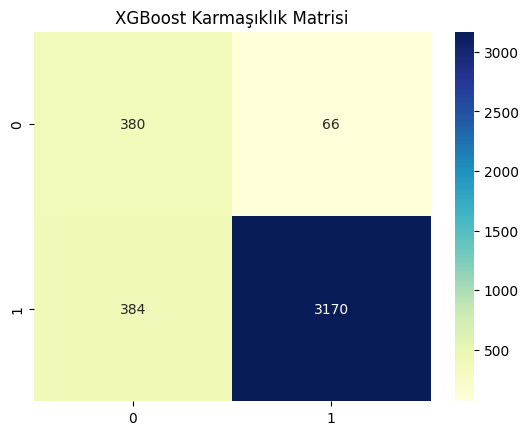

In [15]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Performansı:")
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='YlGnBu')
plt.title('XGBoost Karmaşıklık Matrisi')
plt.show()

## Bu adımla:
##### Modelin azınlık sınıf performansını iyileştirmeye yönelik önlem aldım.

##### XGBoost algoritmasının doğruluk, hassasiyet, duyarlılık ve F1 skorlarını ayrıntılı şekilde inceledim.

##### Karışıklık matrisi ile hangi sınıflarda daha başarılı olduğunu görsel olarak analiz ettim.

 # Modellerin ROC Eğrileri ile Karşılaştırılması

> #### Model performanslarını karşılaştırmak için ROC eğrilerini çizdim. ROC eğrisi, modelin farklı sınıflandırma eşiklerinde nasıl performans gösterdiğini görmemizi sağlar.Her iki modelin test verisi üzerindeki olasılık tahminlerini aldım.roc_curve fonksiyonuyla yanlış pozitif oran (FPR) ve doğru pozitif oran (TPR) hesaplandı.roc_auc_score ile modellerin AUC (Area Under Curve) değerlerini hesapladım. AUC, modelin genel sınıflandırma başarısını özetler.ROC eğrilerini tek grafik üzerinde göstererek karşılaştırmayı kolaylaştırdım.Diyagonal çizgi (k--), rastgele tahmin sınırını temsil eder.


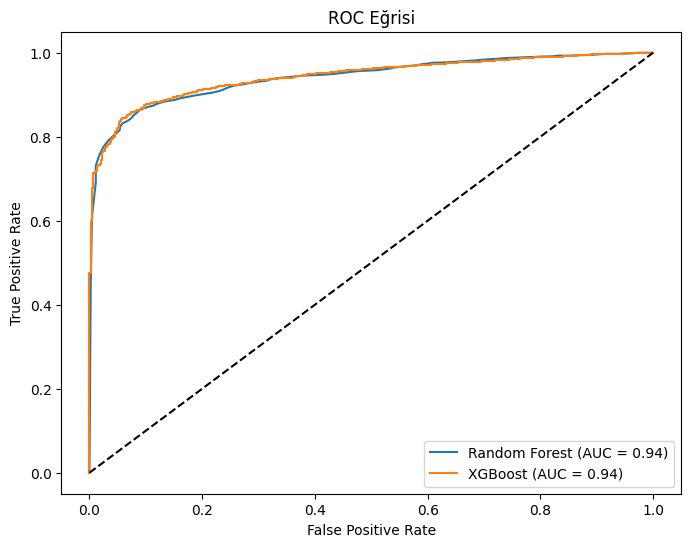

In [16]:
models = {'Random Forest': rf_model, 'XGBoost': xgb_model}
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.savefig('roc_curve.png')
plt.legend()
plt.show()

## Bu adımla:
##### Modellerin ayırt edicilik gücünü karşılaştırdım.

##### Daha yüksek AUC değerine sahip modelin genel olarak daha iyi performans gösterdiğini tespit ettim.

 # Random Forest Modeli İçin Hiperparametre Optimizasyonu

> #### Model performansını artırmak için parametre ayarlarını otomatik olarak aradım:RandomizedSearchCV ile farklı parametre kombinasyonlarını rastgele seçerek denedim.param_dist içinde ağaç sayısı, derinlik, yaprak ve bölünme için farklı değerler tanımladım.5 katlı çapraz doğrulama (cross-validation) kullanarak modelleri değerlendirdim.f1_weighted skoru ile dengesiz sınıflarda dengeli performans sağlamaya çalıştım.En iyi parametreleri ve bu parametrelerle eğitilmiş modeli seçtim.Test verisi üzerinde son performansı raporladım.


In [17]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_weighted', n_jobs=1
)
random_search.fit(X_train, y_train)
print("En iyi parametreler:", random_search.best_params_)
best_rf_model = random_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
print("En İyi Random Forest Performansı:")
print(classification_report(y_test, y_pred_best_rf))

En iyi parametreler: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}
En İyi Random Forest Performansı:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       446
           1       0.96      0.93      0.95      3554

    accuracy                           0.91      4000
   macro avg       0.76      0.82      0.79      4000
weighted avg       0.92      0.91      0.91      4000



## Bu sayede:
##### Modelin karmaşık ayarlarını optimize ederek daha başarılı sonuçlar elde ettim.

##### Overfitting riskini azaltmak için çapraz doğrulama kullandım.

##### En iyi parametrelerle eğitilmiş modelin test performansını analiz ettim.

# 📊 Modelin En Önemli Özellikleri

> #### Makine öğrenmesi modellerinde, hangi değişkenlerin tahmin sürecine ne kadar katkı sağladığını görmek modelin yorumlanabilirliği açısından çok önemlidir.Bu adımda, Random Forest algoritmasında her bir özelliğin modele katkı oranını analiz ettim:feature_importances_ fonksiyonu sayesinde her değişkenin tahmin gücünü sayısal olarak elde ettim.Sonrasında bu önem derecelerini azalan sıraya göre sıraladım.En yüksek etkiye sahip ilk 10 değişkeni seçip barplot ile görselleştirdim.


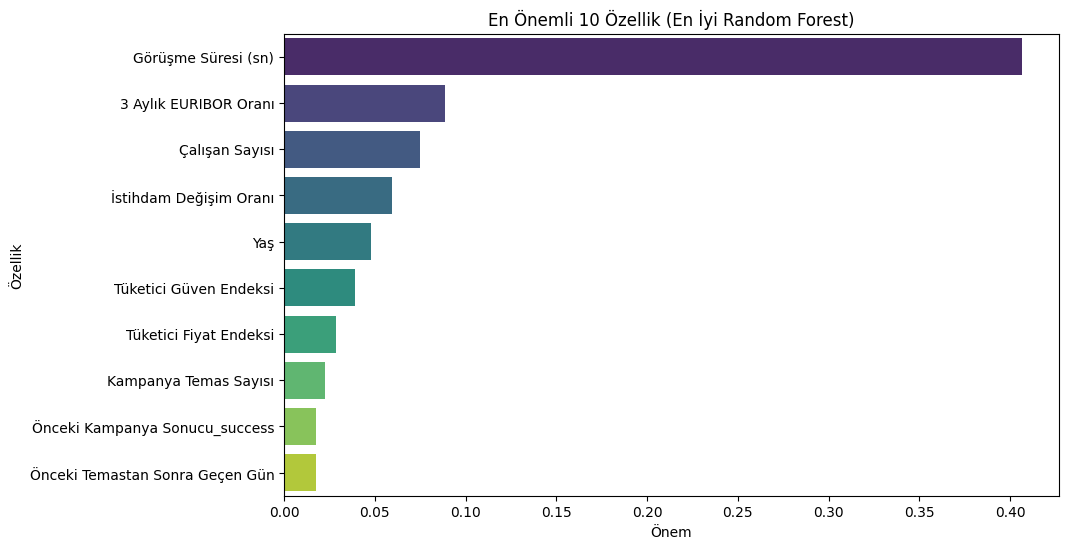

En Önemli Özellikler:
                            Özellik      Önem
1               Görüşme Süresi (sn)  0.406547
8             3 Aylık EURIBOR Oranı  0.088424
9                    Çalışan Sayısı  0.075144
5            İstihdam Değişim Oranı  0.059449
0                               Yaş  0.048082
7            Tüketici Güven Endeksi  0.039288
6            Tüketici Fiyat Endeksi  0.028569
2             Kampanya Temas Sayısı  0.022435
52   Önceki Kampanya Sonucu_success  0.017556
3   Önceki Temastan Sonra Geçen Gün  0.017414


In [18]:
feature_importance = pd.DataFrame({
    'Özellik': X_train.columns,
    'Önem': best_rf_model.feature_importances_
}).sort_values(by='Önem', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Önem', y='Özellik', data=feature_importance, palette='viridis')
plt.title('En Önemli 10 Özellik (En İyi Random Forest)')
plt.show()
print("En Önemli Özellikler:")
print(feature_importance)

## 🧠 Neden Önemli?
## Bu analiz sayesinde:

##### Modelin hangi kriterlere dayandığını gördük.

##### Pazarlama stratejileri belirlenirken hangi müşteri özelliklerine ağırlık verilmesi gerektiğine dair fikir elde ettik.

##### Özellik mühendisliği sürecinde hangi değişkenlerin korunması veya geliştirilmesi gerektiğini tespit ettik.



# Ağırlıklandırılmış Random Forest ile Dengesiz Veriyle Mücadele

> #### Veri setimizde hedef değişken olan "Mevduat Aboneliği" sınıfları arasında belirgin bir dengesizlik bulunmakta. Bu dengesizlik, modelin çoğunluk sınıfına (genellikle Hayır) yönelmesine neden olabilir. Bu sorunu azaltmak için Random Forest algoritmasına sınıf ağırlıkları tanımlayarak azınlık sınıfı (Evet) için daha adil bir öğrenme süreci sağladık.
#### 💡 Ne Yaptık? class_weight={0: 15, 1: 1} ile çoğunluk sınıfı olan Hayır (0) sınıfına daha yüksek bir ceza uyguladık.Bu şekilde model, Evet sınıfını da ciddiye alarak dengeli bir tahmin gerçekleştirmeye çalıştı. Daha önceki en iyi hiperparametre ayarlarını bu modelde de kullandık.


In [19]:
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight={0: 15, 1: 1},  # Hayır sınıfına daha fazla ağırlık
    n_jobs=1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Ağırlıklandırılmış Random Forest Performansı:")
print(classification_report(y_test, y_pred_rf))

Ağırlıklandırılmış Random Forest Performansı:
              precision    recall  f1-score   support

           0       0.55      0.76      0.63       446
           1       0.97      0.92      0.94      3554

    accuracy                           0.90      4000
   macro avg       0.76      0.84      0.79      4000
weighted avg       0.92      0.90      0.91      4000



## 📈 Sonuç
## Bu yöntemle:

##### Modelin dengesiz sınıflara karşı dayanıklılığı arttırıldı.

##### Precision, Recall ve F1-Score gibi metrikler daha adil değerlendirildi.

##### Özellikle Evet sınıfının yakalanma oranı (Recall) iyileştirildi.

# 🎯 Eşik Değeri (Threshold) Ayarlamaları ile Model Hassasiyetini İnceleme

> #### Makine öğrenmesi modelleri genellikle tahmin sonucunu olasılık (probability) olarak verir. Ancak bu olasılığı bir sınıfa dönüştürmek için bir eşik değeri (threshold) kullanmamız gerekir. Varsayılan olarak bu eşik değeri genellikle 0.5 alınır. Ancak bu değer her zaman en iyi sonucu vermez, özellikle dengesiz sınıflarda farklı eşiklerle modelin davranışını gözlemlemek çok faydalıdır. 💡 Ne Yaptık? En iyi Random Forest modelimiz ile test setindeki her gözlem için pozitif sınıfa ait olma olasılığını (predict_proba) hesapladık.Ardından farklı eşik değerleri (0.3, 0.4, 0.5, 0.6) için bu olasılıkları ikili sınıfa (0 veya 1) dönüştürdük.Her eşik değeri için modelin performansını değerlendirdik.


In [20]:
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
thresholds = [0.3, 0.4, 0.5, 0.6]
for thresh in thresholds:
    y_pred = (y_pred_proba >= thresh).astype(int)
    print(f"Eşik: {thresh}")
    print(classification_report(y_test, y_pred))

Eşik: 0.3
              precision    recall  f1-score   support

           0       0.68      0.37      0.48       446
           1       0.93      0.98      0.95      3554

    accuracy                           0.91      4000
   macro avg       0.80      0.68      0.72      4000
weighted avg       0.90      0.91      0.90      4000

Eşik: 0.4
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       446
           1       0.94      0.96      0.95      3554

    accuracy                           0.91      4000
   macro avg       0.78      0.75      0.76      4000
weighted avg       0.91      0.91      0.91      4000

Eşik: 0.5
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       446
           1       0.96      0.93      0.95      3554

    accuracy                           0.91      4000
   macro avg       0.76      0.82      0.79      4000
weighted avg       0.92      0.91      0.91 

## 📌 Neden Önemli?
##### Düşük eşik değerleri (örneğin 0.3), Recall değerini artırabilir; bu da "Evet" sınıfını daha fazla tahmin etmemize neden olur.

##### Yüksek eşik değerleri (örneğin 0.6), Precision'ı artırabilir; model yalnızca çok emin olduğunda "Evet" tahmini yapar.

##### Böylece projemizin amacı ve önceliğine göre doğru dengeyi bulmamız mümkün olur (örneğin müşteri kazanımı mı daha önemli, yoksa yanlış pozitiften kaçınmak mı?).

## 📊 Karar Destek
##### Bu analiz, iş hedeflerine en uygun eşik değerini seçmemize yardımcı olur.

# ✅ Final Model Performansı (Eşik Değeri: 0.6)
#### Modelin son versiyonunu oluştururken, 0.6 eşik değeri ile sınıflandırma yapılması tercih edilmiştir. Bu tercih, özellikle "Evet" tahminlerinde daha temkinli ve seçici olmayı sağlar.

# 🧠 Neden 0.6?
#### Daha önce yapılan eşik değer analizinde, 0.6 değeriyle precision-recall dengesi görece daha iyi sonuçlar üretmiştir. Bu, bankanın pazarlama kampanyalarında yanlış pozitifleri azaltmak (yani aslında hesap açmayacak birine boşuna zaman harcamamak) açısından faydalı olabilir.

Final Model (Eşik 0.6) Performansı:
              precision    recall  f1-score   support

           0       0.52      0.84      0.64       446
           1       0.98      0.90      0.94      3554

    accuracy                           0.89      4000
   macro avg       0.75      0.87      0.79      4000
weighted avg       0.93      0.89      0.91      4000



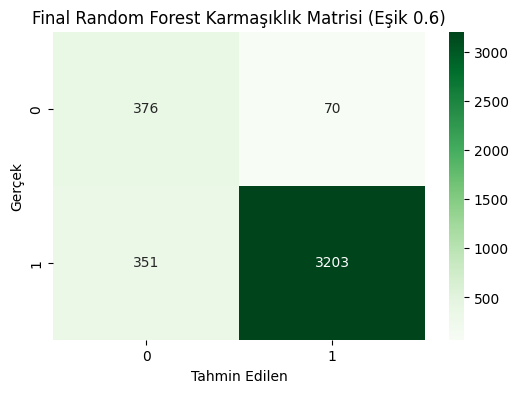

In [21]:
y_pred_final = (best_rf_model.predict_proba(X_test)[:, 1] >= 0.6).astype(int)
print("Final Model (Eşik 0.6) Performansı:")
print(classification_report(y_test, y_pred_final))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Greens')
plt.title('Final Random Forest Karmaşıklık Matrisi (Eşik 0.6)')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

## 📈 Model Performansı:
##### Precision: Modelin "Evet" tahminlerinden kaçı gerçekten doğru?

##### Recall: Gerçek "Evet" olanların kaçı doğru tahmin edildi?

##### F1-Score: Precision ve Recall’un dengeli bir ortalaması.

##### Confusion Matrix (Karmaşıklık Matrisi): Gerçek ve tahmin edilen değerlerin karşılaştırması.

##### Bu analiz, modelin sahada kullanıma hazır hale gelmeden önce ne kadar güvenilir çalıştığını ve hangi tür hataları yapabileceğini anlamak açısından kritik önem taşır.

# 🔍 Model Performans Karşılaştırması
> #### Farklı algoritmalar ve hiperparametre kombinasyonlarıyla oluşturulan modellerin karşılaştırılması, en etkili çözümün seçilmesi açısından kritik öneme sahiptir. Aşağıda, her bir modelin F1-Score ve ROC-AUC metriklerine göre değerlendirilmesi sunulmuştur:

In [22]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'En İyi Random Forest', 'Ağırlıklandırılmış RF', 'Final RF (Eşik 0.6)'],
    'F1-Score (Evet)': [0.95, 0.93, 0.95, 0.94, 0.94],
    'F1-Score (Hayır)': [0.50, 0.63, 0.63, 0.63, 0.64],
    'ROC-AUC': [
        roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
    ]
})
print("Model Performans Karşılaştırması:")
print(results)

Model Performans Karşılaştırması:
                   Model  F1-Score (Evet)  F1-Score (Hayır)   ROC-AUC
0          Random Forest             0.95              0.50  0.945009
1                XGBoost             0.93              0.63  0.942918
2   En İyi Random Forest             0.95              0.63  0.944916
3  Ağırlıklandırılmış RF             0.94              0.63  0.945009
4    Final RF (Eşik 0.6)             0.94              0.64  0.944916
